<a href="https://colab.research.google.com/github/prateekchandrajha/mastering-ml-algorithms/blob/main/Ch_3_Generative_Gaussian_Mixture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Information Retrieval Quiz - 5

Firstly we create a simple bidimensional dataset, created using the `make_blobs()` function provided by scikit-learn.

This function
allows creating synthetic datasets to test algorithms that require data points drawn
from a set of normal distributions. 

The goal of this submission is to show the dynamics
of a ***Generative Gaussian Mixture***, and therefore I have avoided
complex datasets which can't be easily visualized.

Generative Gaussian Mixtures are models that can learn the structure of a dataset
and output the probability of any data point. They are based on both labeled and
unlabeled samples, which are assumed to be equally trustworthy. That is to say,
the unlabeled points contribute to the final positioning of the Gaussians like the
labeled ones.
This algorithm is very fast and produces excellent results in terms of density
estimation.


In [ ]:
from sklearn.datasets import make_blobs
import numpy as np
nb_samples = 250
nb_unlabeled = 200

In [ ]:
X, Y = make_blobs(n_samples=nb_samples, n_features=2, centers=2,
cluster_std=1.25, random_state=100)

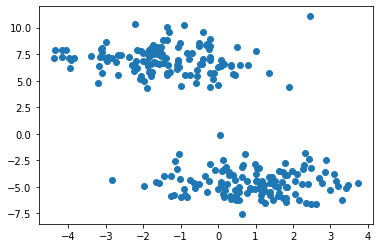

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1])

In [ ]:
unlabeled_idx = np.random.choice(np.arange(0, nb_samples, 1),
replace=False, size=nb_unlabeled)
Y[unlabeled_idx] = -1

We've created 200 samples belonging to 2 classes. 250 points have then been
randomly selected to become our unlabeled dataset (the corresponding class
has been set to -1). 

We can now initialize two Gaussian distributions by defining
their mean, covariance, and weight. One possibility is to use random values; this
choice is the simplest, and doesn't require any prior calculation. The algorithm has
been proven to converge in any case, but the number of steps is a function of the
difference between the initial and final states.

In [ ]:
import numpy as np

m1 = np.random.uniform(-7.5, 10.0, size=2)
c1 = np.random.uniform(5.0, 15.0, size=(2, 2))

c1 = np.dot(c1, c1.T)
q1 = 0.5

m2 = np.random.uniform(-7.5, 10.0, size=2)

c2 = np.random.uniform(5.0, 15.0, size=(2, 2))
c2 = np.dot(c2, c2.T)

q2 = 0.5

In [ ]:
c2

array([[ 84.54170896, 135.43197501],
       [135.43197501, 217.12157236]])

 A
covariance-matrix is is an extension of the concept of variance that must inherit
the same properties. In particular, when the Gaussian is aligned with the axis,
all non-diagonal terms are null. On the diagonal there are the variances with
respect to every component, which are also the eigenvalues. It's straightforward to
understand that all these terms are non-negative.

In [ ]:
m1 = np.array([-2.0, -2.5])
c1 = np.array([[1.0, 1.0],
 [1.0, 2.0]])
q1 = 0.5

m2 = np.array([1.0, 3.0])
c2 = np.array([[2.0, -1.0],
 [-1.0, 3.5]])
q2 = 0.5

In [ ]:
w1, v1 = np.linalg.eigh(c1)
w2, v2 = np.linalg.eigh(c2)

nv1 = v1 / np.linalg.norm(v1)
nv2 = v2 / np.linalg.norm(v2)

a1 = np.arccos(np.dot(nv1[:, 1], [1.0, 0.0]) / np.linalg.norm(nv1[:,
1])) * 180.0 / np.pi
a2 = np.arccos(np.dot(nv2[:, 1], [1.0, 0.0]) / np.linalg.norm(nv2[:,
1])) * 180.0 / np.pi

In [ ]:
from scipy.stats import multivariate_normal
threshold = 1e-4
def total_norm():
    global m1, m1_old, m2, m2_old, c1, c1_old, c2, c2_old, q1, q1_old, q2, q2_old
    return np.linalg.norm(m1 - m1_old) + \
    np.linalg.norm(m2 - m2_old) + \
    np.linalg.norm(c1 - c1_old) + \
    np.linalg.norm(c2 - c2_old) + \
    np.linalg.norm(q1 - q1_old) + \
    np.linalg.norm(q2 - q2_old)


In [ ]:
m1_old = np.zeros((2,))
c1_old = np.zeros((2, 2))
q1_old = 0

m2_old = np.zeros((2,))
c2_old = np.zeros((2, 2))
q2_old = 0

while total_norm() > threshold:
    m1_old = m1.copy()
    c1_old = c1.copy()
    q1_old = q1

    m2_old = m2.copy()
    c2_old = c2.copy()
    q2_old = q2

    Pij = np.zeros((nb_samples, 2))
    # E Step
    for i in range(nb_samples):
      if Y[i] == -1:
          p1 = multivariate_normal.pdf(X[i], m1, c1, allow_singular=True) * q1
          p2 = multivariate_normal.pdf(X[i], m2, c2, allow_singular=True) * q2
          Pij[i] = [p1, p2] / (p1 + p2)
      else:
          Pij[i, :] = [1.0, 0.0] if Y[i] == 0 else [0.0, 1.0]
    # M Step
    n = np.sum(Pij, axis=0)
    m = np.sum(np.dot(Pij.T, X), axis=0)
    m1 = np.dot(Pij[:, 0], X) / n[0]
    m2 = np.dot(Pij[:, 1], X) / n[1]
    q1 = n[0] / float(nb_samples)
    q2 = n[1] / float(nb_samples)
    c1 = np.zeros((2, 2))
    c2 = np.zeros((2, 2))
    for t in range(nb_samples):
        c1 += Pij[t, 0] * np.outer(X[t] - m1, X[t] - m1)
        c2 += Pij[t, 1] * np.outer(X[t] - m2, X[t] - m2)
    c1 /= n[0]
    c2 /= n[1]


In [ ]:
print(np.round(X[Y==-1][0:5], 3))

[[-1.37  10.07 ]
 [ 0.398 -3.857]
 [-1.866  7.496]
 [-0.752 -4.314]
 [ 0.145 -5.932]]
